In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import datetime
import pandas as pd
import numpy as np
#import interpolation

In [8]:
p_j = os.path.join
obs_folder = 'obs_data/2017_August_experiment/2017-08-22/soil moisture'
file_format = 'dat'

In [9]:
'# Defining Sensor Locations'
x = [0.5, 1.5, 2.5, 3.5] * 2 + \
    [0.5, 1.5, 3.5] + \
    [0.5, 2.5, 3.5] * 2 + \
    [0.5, 1.5, 3.5] * 2 + \
    [0.5, 1.5]
y = [0.05] * 4 + [0.1] * 4 + [0.15] * 3 + [0.2] * 3 + [0.25] * 3 + [0.3] * 3 + \
    [0.35] * 3 + [0.4] * 2

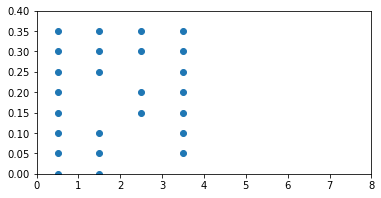

In [195]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.set_xlim(0, 8)
ax.set_ylim(0, 0.4)
ax.scatter(x, 0.4 - np.array(y))


In [10]:
'# Setting Experiment Start Time and Elapsed Time to be Examined'
elapsed_time = 13000
start = datetime.datetime(2017,8,22,12,34,4)

In [109]:
# Flume dimensions
flume_length = 8 # Length of the flume
flume_width = 0.25 # Width of the flume
sand_height = 0.45 # Height of the sand medium
dh_dl = 0.455 / 0.45 # Slope of the flumes

stream_toe_observed = pd.read_csv('./obs_data/stream_length.dat')
stream_toe_observed.loc[:, 'Flow [m$^3$/s]'] = stream_toe_observed['Flow [L/min]'] / 60. / 1000. 
stream_toe_observed.loc[:, 'K [m/s]'] = stream_toe_observed.apply(
    lambda x: x['Flow [L/min]'] / 1000. / 60. / (flume_width * x[' Streamflow Length [m]']) / dh_dl, axis=1)

/var/folders/3r/w22zb81102dc4rcc4rb5rxmr0000gr/T/ipykernel_42543/2376068215.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  lambda x: x['Flow [L/min]'] / 1000. / 60. / (flume_width * x[' Streamflow Length [m]']) / dh_dl, axis=1)


In [11]:
'# Importing Soil Moisture Sensor Data into Data Frames'
files = ['CR1000_36091_Table1.{}'.format(file_format), 
         'CR1000_36146_Table1.{}'.format(file_format), 
         'CR1000_80326_Table1.{}'.format(file_format), 
         'CR3000_flume_Table1.{}'.format(file_format), 
         'CR3000_FU_Table1.{}'.format(file_format)]


In [12]:
'# Logger Sampling Frequencies (sec)'
sampling_frequencies = {'CR1000_36091': 2,
                        'CR1000_36146': 5,
                        'CR1000_80326': 2,
                        'CR3000_flume': 5,
                        'CR3000_FU': 5}

names = [fle.split('.')[0].replace('_Table1', '') for fle in files]
         
df_data = {}       
sensors = {}
  
for fle in files:         
    name = fle.split('.')[0].replace('_Table1', '')
    if file_format in ['xlsx', 'xls']:
        df_data[name] = pd.read_excel(p_j(obs_folder, fle), header=1, na_values='NAN')
    elif file_format in ['dat', 'csv']:
        df_data[name] = pd.read_csv(p_j(obs_folder, fle), na_values='NAN', skiprows=[0, 2, 3], index_col='TIMESTAMP')

    # Some sensors have VWC and some have VW data ...
    # this next bit of code places preference on the VWC column if both exist
    # and doesn't rename the column with VW. This is important as only columns
    # beginning with and 'S' are processed further
    tmp_vwc = [c.replace("VWC_", "") for c in df_data[name].columns]
    tmp_vc = [c.replace("VW_", "").replace("_Avg", "") for c in df_data[name].columns]
    duplicates = list(set([s for s in tmp_vwc if s[0] == 'S']).intersection( 
                 [s for s in tmp_vc if s[0] == 'S']))
    # Deal with CR1000 naming of sensors
    df_data[name].columns = [c.replace("VWC_", "") for c in df_data[name].columns]
    # Deal with CR3000 naming of sensors
    tmp_col = [c.replace("VW_", "").replace("_Avg", "") if \
               c.replace("VW_", "").replace("_Avg", "") not in duplicates else \
               c for c in df_data[name].columns ]
    df_data[name].columns = tmp_col
    for col in df_data[name].columns:
        if col[0] == 'S':
            sensors[col] = {'name':name}
    df_data[name]['TIMESTAMP'] = df_data[name].index
    df_data[name]['TIMESTAMP'] = pd.to_datetime(df_data[name]['TIMESTAMP'])
    for col in df_data[name].columns:
        if col not in ['TIMESTAMP', 'RECORD']:
            df_data[name][col]= df_data[name][col].astype(float)

if not start:
    for index, name in enumerate(names):
        if index == 0:
            start = df_data[name].loc[0, 'TIMESTAMP']
        else:
            if df_data[name].loc[0, 'TIMESTAMP'] < start:
                start = df_data[name].loc[0, 'TIMESTAMP']
        # end if
    # end for
# end if

In [13]:
'# Appending an Elapsed Time Column to Data Frames'
logger_sensor_map = {}
sensor_logger_map = {}
for name in names:
    df_data[name].loc[:, 'Elapsed Time'] = [t.total_seconds() for t in (df_data[name]['TIMESTAMP'] - start)]
    logger_sensor_map[name] = [s for s in df_data[name].columns if s[0] == 'S']
    for s in df_data[name].columns:
        if s[0] == 'S':    
            sensor_logger_map[s] = name
# end  for

In [14]:
# Conversion to % saturation is done via an equation of the form:
# sat% = (x + a) / (b - c) * 100
saturation_conversion_functions = {
     'S1_8': lambda x: (x - 1.83) / (37.58 - 1.83) * 100,
     'S2_8': lambda x: (x - 2.26) / (41.71 - 2.26) * 100,
     'S3_8': lambda x: (x - 2.08) / (39.05 - 2.08) * 100,
     'S4_8': lambda x: (x - 0.002) / (0.112 - 0.002) *100,
     'S1_7': lambda x: (x - 4.91) / (37.75 - 4.91) * 100,
     'S2_7': lambda x: (x - 6.17) / (38.48 - 6.17) * 100,
     'S3_7': lambda x: (x - 6.53) / (37.58 - 6.53) * 100,
     'S4_7': lambda x: (x - 0.010) / (0.122 - 0.010) * 100,
     'S1_6': lambda x: (x - 6.47) / (37.47 - 6.47) * 100,
     'S2_6': lambda x: (x - 8.03) / (36.34 - 8.03) * 100,
     'S4_6': lambda x: (x - 0.016) / (0.117 - 0.016) * 100,
     'S1_5': lambda x: (x - 8.08) / (37.35 - 8.08) * 100,
     'S3_5': lambda x: (x - 0.014) / (0.134 - 0.014) * 100,
     'S4_5': lambda x: (x - 0.016) / (0.137 - 0.016) * 100,
     'S1_4': lambda x: (x - 9.82) / (38.60 - 9.82) * 100,
     'S3_4': lambda x: (x - 0.058) / (0.331 - 0.058) * 100,
     'S4_4': lambda x: (x - 0.016) / (0.133 - 0.016) * 100,
     'S1_3': lambda x: (x - 9.28) / (38.06 - 9.28) * 100,
     'S2_3': lambda x: (x - 9.40) / (37.70 - 9.40) * 100,
     'S4_3': lambda x: (x - 0.015) / (0.126 - 0.015) * 100,
     'S1_2': lambda x: (x - 8.98) / (37.35 - 8.98) * 100,
     'S2_2': lambda x: (x - 9.82) / (35.88 - 9.82) * 100,
     'S4_2': lambda x: (x - 0.017) / (0.123 - 0.017) * 100,
     'S1_1': lambda x: (x - 8.15) / (38.43 - 8.15) * 100,
     'S2_1': lambda x: (x - 9.82) / (39.11 - 9.82) * 100}

In [15]:
# Specify the sensors that worked to allow filtering of bad ones
sensors_of_interest = ['S1_8', 'S2_8', 'S3_8', 'S4_8', 
                       'S1_7', 'S2_7', 'S3_7', 'S4_7', 
                       'S1_6', 'S2_6', 'S4_6',
                       'S1_5', 'S3_5', 'S4_5',
                       'S1_4', 'S3_4', 'S4_4',
                       'S1_3', 'S2_3', 'S4_3',
                       'S1_2', 'S2_2', 'S4_2',
                       'S1_1', 'S2_1']

In [16]:
def sensor_vals_at_elapsed_time(elapsed_time, df_data, sensors, sampling_frequencies, 
                                sensors_of_interest, saturation_conversion_functions):
    '# Extracting Sensor Data at Elapsed Time'
    for name in names:
        df_data[name].loc[:, 'Elapsed Time diff'] = np.abs(df_data[name]['Elapsed Time'] - elapsed_time)           
        df = df_data[name]
        df.index = df['Elapsed Time']
        df[df['Elapsed Time diff'] <= sampling_frequencies[name] / 2.][[col for col in df.columns if col[0] =='S'] + ['Elapsed Time']]
        closest_indices = np.sort(df['Elapsed Time diff'].copy().sort_values().index.tolist()[0:2])
        if elapsed_time in closest_indices:
            closest_indices = [elapsed_time]
            for col in df_data[name].columns:
                if col[0] == 'S':
                    sensors[col][elapsed_time] = df.loc[elapsed_time, col]
        else:
            df_relevant = df.loc[closest_indices]
            df_relevant = df_relevant.append(pd.DataFrame({cod:np.nan for cod in df_relevant.columns}, index=[elapsed_time]))
            df_relevant = df_relevant.reindex(df_relevant.index.sort_values())
            df_relevant.interpolate(method='index', inplace=True)
            for col in df_data[name].columns:
                if col[0] == 'S':
                    sensors[col][elapsed_time] = df_relevant.loc[elapsed_time, col]
    
    # Saturation Percentage Vector       

    z = [saturation_conversion_functions[sensor](sensors[sensor][elapsed_time]) for sensor in sensors_of_interest]
 
    return sensors, z 

In [44]:
# Read in the modelling results:
prefix = 'flume_new'
sim_fname_dict =\
    {sensor:'{}o.observation_well_flow.{}.dat'.format(prefix, sensor.replace('_','-')) for sensor in 
     sensors_of_interest} 
sim_dfs = {}

def get_header(fname):
    with open(fname, 'r') as f:
        header = f.readlines()[1].split('=')[1].replace('"', '').replace('\n', '').replace(' ', '').split(',')
    return header
    
for key in sim_fname_dict:
    sim_dfs[key] = pd.read_csv(sim_fname_dict[key], names=get_header(sim_fname_dict[key]), 
                               skiprows=2, delim_whitespace=True)

In [42]:
max_c = int(max([s[1] for s in sensors_of_interest]))
max_r = int(max([s[3] for s in sensors_of_interest]))

In [72]:
bad_sensors = list(set(sensors_of_interest_new) - set(sensors_of_interest))

In [74]:
sensors_of_interest_new = []
for i in range(1, 5):
    for j in range(8, 0, -1):
        sensors_of_interest_new += [f"S{i}_{j}"]

In [100]:
def plot_flux_changes(ax):
    for flux_change in flux_changes:
        ax.axvline(flux_change, linestyle='--', color='grey', alpha=0.4)
# Time of change of flux in flume experiments
flux_changes = [0, 1816, 3273, 4800, 7020, 9004, 10850, 12120, 13800, 15200] 

# Plot of observed vs simulated saturation sensor time series

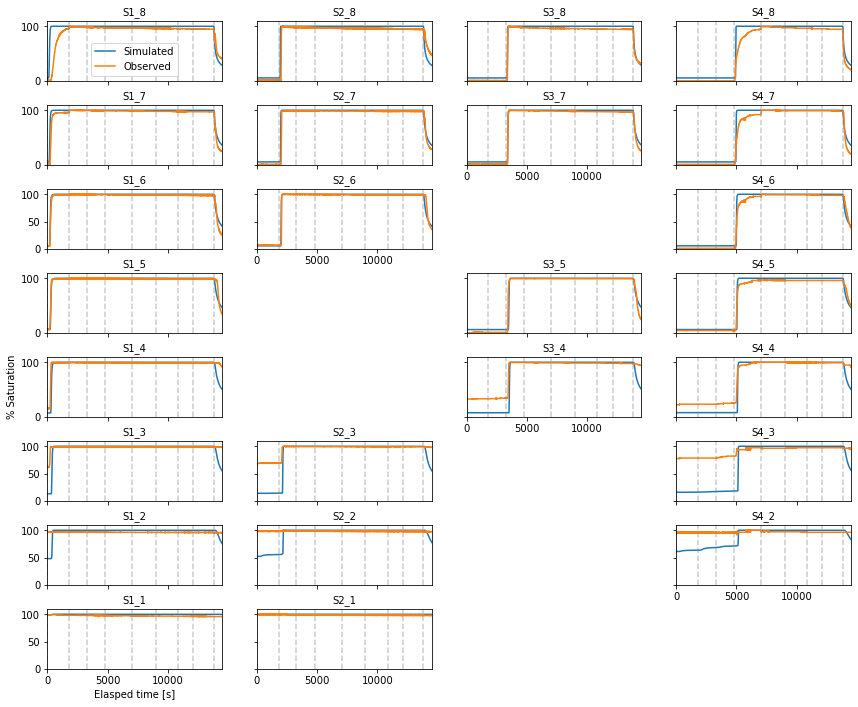

In [144]:
# Combined plot
fig = plt.figure(figsize=(12, 10))
for index, sensor in enumerate(sensors_of_interest_new):
    if sensor in bad_sensors:
        continue
    #print(sensor)
    ax = fig.add_subplot(max_r, max_c, int(sensor[1]) +  int(max_c) * (int(max_r) - int(sensor[3])))
    sim = sim_dfs[sensor]
    sim.loc[:,'Time [hr]'] = sim['Time'] / 60.0 / 60.
    sim.loc[:,'Time [hr]'] = sim.loc[:,'Time [hr]'] - 90 * 24
    ax.plot(sim['Time'] - 90 * 24 *60 *60, sim['S'] * 100., label='Simulated')
    obs = df_data[sensor_logger_map[sensor]][['Elapsed Time', sensor]]
    obs = obs[obs['Elapsed Time'] >= 0.]
    obs.loc[:,'Time [hr]'] = obs['Elapsed Time'] / 60.0  / 60.
    obs[sensor] = obs[sensor].apply(saturation_conversion_functions[sensor])
    ax.plot(obs['Elapsed Time'], obs[sensor], label='Observed')
    ax.set_ylim(0, 110)
    keep_x_labels = [[1,1], [2,1], [2,6], [3, 7], [3, 4], [4,2]]
    if int(sensor[1]) > 1:
        ax.set_yticklabels('')
    elif int(sensor[3]) == 4:
        ax.set_ylabel('% Saturation')
    if [int(sensor[1]), int(sensor[3])] not in keep_x_labels:
        ax.set_xticklabels('')
    elif int(sensor[1]) == 1:
        ax.set_xlabel('Elasped time [s]')
    #ax.legend()
    ax.set_title(sensor, fontsize=10)
    plot_flux_changes(ax)
    ax.set_xlim(0, 4.025 * 60 * 60)
    if index == 0:
        ax.legend()    
#-----------------------------------------------------------------------------    
#ax = fig.add_subplot(max_r, max_c, 31)
#ax.scatter([0.500, 1.500, 2.500, 3.500], [1, 1, 1, 1])
#for ind, val in enumerate([0.500, 1.500, 2.500, 3.500]):
#    ax.text(val - 0.05, 1.004, f"S{ind+1}", color='blue')
#ax.axvline(0, linestyle="--", color='grey')
#for ind, front in enumerate(stream_toe_observed[' Streamflow Length [m]']):
#    ax.axvline(front, linestyle="--", color='red')
#    ax.text(front + 0.03, 1.04, f"Q{ind+1}", color='red')
#ax.set_xlabel("Distance from start of flume [m]")
#ax.set_yticklabels("")
#-----------------------------------------------------------------------------    
    
fig.subplots_adjust(hspace=0.4, bottom=0.06, top=0.96, left=0.05, right=0.98)    
plt.savefig("Obs_vs_sim_saturation.png", dpi=300)

# Consideration of vertical sensor lines relative to stream wetting front maximums to aid interpretation of the observed satuation sensor time-series

[Text(0, 0.9, ''),
 Text(0, 0.9500000000000001, ''),
 Text(0, 1.0, ''),
 Text(0, 1.05, ''),
 Text(0, 1.1, '')]

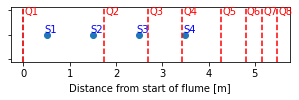

In [130]:
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)
ax.scatter([0.500, 1.500, 2.500, 3.500], [1, 1, 1, 1])
for ind, val in enumerate([0.500, 1.500, 2.500, 3.500]):
    ax.text(val - 0.05, 1.004, f"S{ind+1}", color='blue')
ax.axvline(0, linestyle="--", color='grey')
for ind, front in enumerate(stream_toe_observed[' Streamflow Length [m]']):
    ax.axvline(front, linestyle="--", color='red')
    ax.text(front + 0.03, 1.04, f"Q{ind+1}", color='red')
ax.set_xlabel("Distance from start of flume [m]")
ax.set_yticklabels("")